In [1]:
%matplotlib inline
import bnpy
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
import os
import pickle
import matplotlib.pyplot as plt
import gzip

from subprocess import Popen, PIPE
from threading import Timer
from scipy.stats import iqr, percentileofscore
from statsmodels import robust
from sklearn.metrics import roc_curve, auc

date = str(datetime.date.today())

In [2]:
pth = '../data/TCGA-glioblastoma-multiforme-log2TPM1.tsv'

nbl = pd.read_csv(pth, sep='\t', index_col=0)

In [3]:
pth = '../data/h.all.v6.2.symbols.gmt'

gss = {}
gss_mean_mean = {}
gss_median_mean = {}
gss_mean_mad = {}
with open(pth) as f:
    for line in f:
        fields = line.strip().split()
        gss[fields[0]] = fields[2:]
        _mean = nbl.reindex(fields[2:]).dropna().mean(axis=1).mean()
        gss_mean_mean[fields[0]] = _mean

In [4]:
mformat = {'hydra': 'Hydra',
           'ssgsea': 'ssGSEA',
           'gsva': 'GSVA'}

mcolor = {'hydra': '#003050',
          'ssgsea': '#7096a0',
          'gsva': '#b0b7a7'}

In [5]:
import uuid
import numpy as np


def fit(xdata):
    #data = data.apply(lambda x: x - x.mean(), axis=1)
    #data = data.T.values

    #xdata = bnpy.data.XData(data)

    gamma = 5.0
    sF = 2.0
    K = 2

    hmodel, info_dict = bnpy.run(
        xdata, 'DPMixtureModel', 'Gauss', 'memoVB',
        output_path=('/tmp/%s/' % uuid.uuid4() +
            'trymoves-K=%d-gamma=%s-ECovMat=%s*eye-moves=merge,shuffle/' % (
                K, gamma, sF)),
        nLap=1000, nTask=1, nBatch=1,
        gamma0=gamma, sF=sF, ECovMat='eye',
        K=K, initname='randexamplesbydist',
        moves='birth,merge,delete,shuffle',
        b_startLap=0,
        m_startLap=2,
        d_startLap=2,
        doWriteStdOut=False)
    
    return hmodel, xdata

def get_assignments(model, data):
    """
    Takes model and data and classifies samples

    Will label samples with -1 cluster if they do not
    fit in any of the model components

    :param model:
    :param data:
    :return:
    """
    unclass = 1 - np.sum(model.allocModel.get_active_comp_probs())
    # Get the sample assignments
    LP = model.calc_local_params(data)
    asnmts = []
    for row in range(LP['resp'].shape[0]):
        _max = np.max(LP['resp'][row, :])
        if _max < unclass:
            print 'Could not classify sample'
            asnmts.append(-1)

        else:
            _arg = np.argmax(LP['resp'][row, :])
            #print row
            #print LP['resp'][row, :]
            asnmts.append(_arg)

    return asnmts

In [6]:
def get_hydra_auc(hydra_dir, tag, gs, test):
    model_pth = os.path.join(hydra_dir, 
                                 tag, 
                                 gs, 
                                 'MultivariateAnalysis', 
                                 gs)
    
    try:
        model = bnpy.ioutil.ModelReader.load_model_at_prefix(model_pth,
                                                         prefix=gs) 
    except IOError:
        print ("WARNING: Missing Model! ", gs, tag)
        return np.nan, np.nan, np.nan
    
    train_data_pth = os.path.join(hydra_dir, 
                                  tag, 
                                  gs, 
                                  'MultivariateAnalysis', 
                                  gs, 
                                  'training-data.tsv')
    
    train = pd.read_csv(train_data_pth, 
                        sep='\t', 
                        index_col=0)
        
    train_mean = train.mean(axis=1)
    train_center = train.sub(train_mean, axis=0)
    train_xdata = bnpy.data.XData(train_center.values.T)
    
    model, xdata = fit(train_xdata)
    #print model.allocModel.get_active_comp_probs()
    
    maxi = None
    max_mean = None
    for i in range(len(model.allocModel.get_active_comp_probs())):
        mean = model.obsModel.get_mean_for_comp(i)
        norm = np.linalg.norm(mean)
        if norm > max_mean:
            maxi = i
            max_mean = norm
    
    test = test.reindex(train.index)
    test_center = test.sub(train_mean, axis=0)
    test_xdata = bnpy.data.XData(test_center.values.T)
    
    LP = model.calc_local_params(test_xdata)
    probs = LP['resp']
    asnmts = LP['resp'].argmax(axis=1)
    
    test_labels = []
    for j, sample in enumerate(test.columns):
        if 'active' in sample:
            test_labels.append(1)
            
        elif 'normal' in sample:
            test_labels.append(-1)
            
        else:
            raise ValueError()
            
    scores = probs[:, maxi].flatten()
    fpr, tpr, thresholds = roc_curve(test_labels, scores, pos_label=1)
    
    return auc(fpr, tpr), fpr, tpr


def get_ssgsea_auc(tag, gs, test, date):
    ssgsea_pth = os.path.join('../data/output', date, 'ssGSEA', tag, gs)
    ssgsea = pd.read_csv(ssgsea_pth, sep='\t', index_col=0)
    ssgsea.columns = [x.replace('.', '-') for x in ssgsea.columns]
    
    ssgsea_scores = []
    for sample in ssgsea.columns:
        score = ssgsea.loc[gs, sample]
        perc = percentileofscore(ssgsea[sample].sort_values().values, score)
        #ssgsea_scores.append((100 - perc) / 100.)
        ssgsea_scores.append(score)
        
    test_labels = []
    for j, sample in enumerate(test.columns):
        if 'active' in sample:
            test_labels.append(1)
            
        elif 'normal' in sample:
            test_labels.append(-1)
            
        else:
            raise ValueError()
        
    fpr, tpr, thresholds = roc_curve(test_labels, ssgsea_scores, pos_label=1)
    return auc(fpr, tpr), fpr, tpr


def get_gsva_auc(tag, gs, test, date):
    gsva_pth = os.path.join('../data/output', date, 'GSVA', tag, gs)
    gsva = pd.read_csv(gsva_pth, sep='\t', index_col=0)
    gsva.columns = [x.replace('.', '-') for x in gsva.columns]
    
    gsva_scores = []
    for sample in gsva.columns:
        score = gsva.loc[gs, sample]
        perc = percentileofscore(gsva[sample].values, score)
        #gsva_scores.append((100 - perc) / 100.)
        gsva_scores.append(score)
        
    test_labels = []
    for j, sample in enumerate(test.columns):
        if 'active' in sample:
            test_labels.append(1)
            
        elif 'normal' in sample:
            test_labels.append(-1)
            
        else:
            raise ValueError()
        
    fpr, tpr, thresholds = roc_curve(test_labels, gsva_scores, pos_label=1)
    return auc(fpr, tpr), fpr, tpr

In [7]:
import glob
import re

aucs = {}
aucs['hydra'] = {}
aucs['ssgsea'] = {}
aucs['gsva'] = {}

# {method: {gs: {%DEG: eff: tpr}}}
datar = {}
for m in ['hydra', 'ssgsea', 'gsva']:
    datar[m] = {}
    for d in ['0.10', '0.25']:
        datar[m][d] = {}
        for e in ['0.25', '0.50', '0.75', '1.00', '1.50', '2.00', '2.50', '3.00']:
            datar[m][d][e] = {}

plot_df = pd.DataFrame(columns = ['method', 'gene-set', 'auc', 'gs_mean', 'effect', 'difffrac'])

dates = ['2019-09-07', '2019-10-02']
for date in dates:
    input_dir = os.path.join('../data/input', date)
    output_dir = os.path.join('../data/output', date)
    hydra_dir = os.path.join(output_dir, 'Hydra')

    train_pths = os.path.join('../data/input', date, '*train*eff-*')
    regex = re.compile('(?P<gs>HALLMARK_\w*).*-eff-(?P<eff>\d\.\d*)-diff-(?P<diff>\d\.\d*)-frac-(?P<frac>\d\.\d*)')
    for _pth in glob.glob(train_pths):
        print _pth 
        m = regex.search(_pth)
        if not m:
            raise ValueError()
        
        tag = "eff-%s-diff-%s-frac-%s" % m.groups()[1:]
        exp = pd.read_csv(_pth, sep='\t', index_col=0)  
        gs = m.group('gs')
        print gs, tag
    
        # Pull in degs
        deg_pth = os.path.join(input_dir, 'synthetic-%s-degs-%s-%s.tsv' % (gs, tag, date))   
        degs = []
        with open(deg_pth, 'r') as f:
            for line in f:
                degs.append(line.strip())   
    
        test = pd.read_csv(_pth.replace('train', 'test'), 
                           sep='\t', 
                           index_col=0)
    
        try:
            # Hydra
            aucs['hydra'][gs], fpr, tpr = get_hydra_auc(hydra_dir, tag, gs, test)
            plot_df.loc[len(plot_df), :] = ['Hydra', 
                                            gs, 
                                            aucs['hydra'][gs], 
                                            gss_mean_mean[gs], 
                                            m.group('eff'),
                                            m.group('diff')]
            print 'Hydra AUC: ', aucs['hydra'][gs]
            datar['hydra'][m.group('diff')][m.group('eff')][gs] = (fpr, tpr)
    
            # ssGSEA
            aucs['ssgsea'][gs], fpr, tpr = get_ssgsea_auc(tag, gs, test, date)
            plot_df.loc[len(plot_df), :] = ['ssGSEA', gs, aucs['ssgsea'][gs], gss_mean_mean[gs], m.group('eff'),
                                            m.group('diff')]
            print 'ssGSEA AUC: ', aucs['ssgsea'][gs]
            datar['ssgsea'][m.group('diff')][m.group('eff')][gs] = (fpr, tpr)
    
            # GSVA
            aucs['gsva'][gs], fpr, tpr = get_gsva_auc(tag, gs, test, date)
            plot_df.loc[len(plot_df), :] = ['GSVA', gs, aucs['gsva'][gs], gss_mean_mean[gs], m.group('eff'),
                                    m.group('diff')]
            print 'GSVA AUC: ', aucs['gsva'][gs]
            datar['gsva'][m.group('diff')][m.group('eff')][gs] = (fpr, tpr)
        
        except IOError:
            print("Missing: ", gs)
            continue

../data/input/2019-09-07/synthetic-HALLMARK_UNFOLDED_PROTEIN_RESPONSE-train-eff-0.50-diff-0.25-frac-0.16-2019-09-07.tsv.gz
HALLMARK_UNFOLDED_PROTEIN_RESPONSE eff-0.50-diff-0.25-frac-0.16
Hydra AUC:  0.9990906084656085
ssGSEA AUC:  0.5847387566137565
GSVA AUC:  0.6378141534391535
../data/input/2019-09-07/synthetic-HALLMARK_WNT_BETA_CATENIN_SIGNALING-train-eff-0.50-diff-0.25-frac-0.17-2019-09-07.tsv.gz
HALLMARK_WNT_BETA_CATENIN_SIGNALING eff-0.50-diff-0.25-frac-0.17
Hydra AUC:  0.5
ssGSEA AUC:  0.5944562563981416
GSVA AUC:  0.5810693755413812
../data/input/2019-09-07/synthetic-HALLMARK_MYC_TARGETS_V1-train-eff-1.50-diff-0.10-frac-0.19-2019-09-07.tsv.gz
HALLMARK_MYC_TARGETS_V1 eff-1.50-diff-0.10-frac-0.19
Hydra AUC:  0.9999278030467115
ssGSEA AUC:  0.6049382716049383
GSVA AUC:  0.5961302433037325
../data/input/2019-09-07/synthetic-HALLMARK_KRAS_SIGNALING_DN-train-eff-1.00-diff-0.10-frac-0.36-2019-09-07.tsv.gz
HALLMARK_KRAS_SIGNALING_DN eff-1.00-diff-0.10-frac-0.36
Hydra AUC:  0.9218267746

HALLMARK_ALLOGRAFT_REJECTION eff-3.00-diff-0.25-frac-0.26
Hydra AUC:  1.0
ssGSEA AUC:  0.8693693693693694
GSVA AUC:  0.7525410025410025
../data/input/2019-09-07/synthetic-HALLMARK_APOPTOSIS-train-eff-2.50-diff-0.10-frac-0.18-2019-09-07.tsv.gz
HALLMARK_APOPTOSIS eff-2.50-diff-0.10-frac-0.18
Hydra AUC:  1.0
ssGSEA AUC:  0.7139415838602831
GSVA AUC:  0.6921108099969888
../data/input/2019-09-07/synthetic-HALLMARK_APICAL_SURFACE-train-eff-1.50-diff-0.25-frac-0.29-2019-09-07.tsv.gz
HALLMARK_APICAL_SURFACE eff-1.50-diff-0.25-frac-0.29
Hydra AUC:  0.9826237116183691
ssGSEA AUC:  0.9045383411580594
GSVA AUC:  0.780907668231612
../data/input/2019-09-07/synthetic-HALLMARK_IL2_STAT5_SIGNALING-train-eff-0.25-diff-0.25-frac-0.39-2019-09-07.tsv.gz
HALLMARK_IL2_STAT5_SIGNALING eff-0.25-diff-0.25-frac-0.39
Hydra AUC:  0.9907524169819251
ssGSEA AUC:  0.6027742749054225
GSVA AUC:  0.5790948577833823
../data/input/2019-09-07/synthetic-HALLMARK_ANDROGEN_RESPONSE-train-eff-2.50-diff-0.10-frac-0.25-2019-09-0

HALLMARK_HEME_METABOLISM eff-2.50-diff-0.10-frac-0.20
Hydra AUC:  1.0
ssGSEA AUC:  0.828888888888889
GSVA AUC:  0.6859027777777778
../data/input/2019-09-07/synthetic-HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION-train-eff-2.50-diff-0.10-frac-0.30-2019-09-07.tsv.gz
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION eff-2.50-diff-0.10-frac-0.30
Hydra AUC:  1.0
ssGSEA AUC:  0.6492592592592592
GSVA AUC:  0.6198412698412699
../data/input/2019-09-07/synthetic-HALLMARK_KRAS_SIGNALING_UP-train-eff-0.25-diff-0.25-frac-0.23-2019-09-07.tsv.gz
HALLMARK_KRAS_SIGNALING_UP eff-0.25-diff-0.25-frac-0.23
Hydra AUC:  0.9664972708450968
ssGSEA AUC:  0.629713281887195
GSVA AUC:  0.6036765167199951
../data/input/2019-09-07/synthetic-HALLMARK_G2M_CHECKPOINT-train-eff-2.50-diff-0.25-frac-0.26-2019-09-07.tsv.gz
HALLMARK_G2M_CHECKPOINT eff-2.50-diff-0.25-frac-0.26
Hydra AUC:  1.0
ssGSEA AUC:  0.8475398475398476
GSVA AUC:  0.7664010164010164
../data/input/2019-09-07/synthetic-HALLMARK_ESTROGEN_RESPONSE_LATE-train-eff-2.50-

HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY eff-1.00-diff-0.10-frac-0.29
Hydra AUC:  0.9900167287248394
ssGSEA AUC:  0.6052560574173008
GSVA AUC:  0.6060655118450164
../data/input/2019-09-07/synthetic-HALLMARK_BILE_ACID_METABOLISM-train-eff-1.00-diff-0.10-frac-0.30-2019-09-07.tsv.gz
HALLMARK_BILE_ACID_METABOLISM eff-1.00-diff-0.10-frac-0.30
Hydra AUC:  0.8757142857142857
ssGSEA AUC:  0.637989417989418
GSVA AUC:  0.6222751322751323
../data/input/2019-09-07/synthetic-HALLMARK_ANGIOGENESIS-train-eff-3.00-diff-0.25-frac-0.32-2019-09-07.tsv.gz
HALLMARK_ANGIOGENESIS eff-3.00-diff-0.25-frac-0.32
Hydra AUC:  1.0
ssGSEA AUC:  0.884344362745098
GSVA AUC:  0.7417790032679737
../data/input/2019-09-07/synthetic-HALLMARK_COMPLEMENT-train-eff-1.00-diff-0.10-frac-0.39-2019-09-07.tsv.gz
HALLMARK_COMPLEMENT eff-1.00-diff-0.10-frac-0.39
Hydra AUC:  0.9980850964457523
ssGSEA AUC:  0.5247769837933772
GSVA AUC:  0.5083368362056887
../data/input/2019-09-07/synthetic-HALLMARK_KRAS_SIGNALING_UP-train-eff-1.00-dif

HALLMARK_SPERMATOGENESIS eff-0.25-diff-0.10-frac-0.19
Hydra AUC:  0.8891776767020431
ssGSEA AUC:  0.449065049454913
GSVA AUC:  0.49851996245758423
../data/input/2019-09-07/synthetic-HALLMARK_MYC_TARGETS_V1-train-eff-1.00-diff-0.25-frac-0.38-2019-09-07.tsv.gz
HALLMARK_MYC_TARGETS_V1 eff-1.00-diff-0.25-frac-0.38
Hydra AUC:  1.0
ssGSEA AUC:  0.65275419732126
GSVA AUC:  0.6667609884927372
../data/input/2019-09-07/synthetic-HALLMARK_KRAS_SIGNALING_UP-train-eff-2.00-diff-0.10-frac-0.36-2019-09-07.tsv.gz
HALLMARK_KRAS_SIGNALING_UP eff-2.00-diff-0.10-frac-0.36
Hydra AUC:  1.0
ssGSEA AUC:  0.7351948302469137
GSVA AUC:  0.6147280092592593
../data/input/2019-09-07/synthetic-HALLMARK_ADIPOGENESIS-train-eff-3.00-diff-0.25-frac-0.23-2019-09-07.tsv.gz
HALLMARK_ADIPOGENESIS eff-3.00-diff-0.25-frac-0.23
Hydra AUC:  1.0
ssGSEA AUC:  0.999874521613652
GSVA AUC:  0.9013739883305101
../data/input/2019-09-07/synthetic-HALLMARK_MYC_TARGETS_V1-train-eff-3.00-diff-0.25-frac-0.19-2019-09-07.tsv.gz
HALLMARK_MYC_

HALLMARK_ANGIOGENESIS eff-1.50-diff-0.25-frac-0.21
Hydra AUC:  0.9592793516844149
ssGSEA AUC:  0.7262741946286251
GSVA AUC:  0.7549393878507802
../data/input/2019-09-07/synthetic-HALLMARK_TNFA_SIGNALING_VIA_NFKB-train-eff-0.25-diff-0.25-frac-0.28-2019-09-07.tsv.gz
HALLMARK_TNFA_SIGNALING_VIA_NFKB eff-0.25-diff-0.25-frac-0.28
Hydra AUC:  0.9834104938271605
ssGSEA AUC:  0.5211089065255732
GSVA AUC:  0.49289021164021163
../data/input/2019-09-07/synthetic-HALLMARK_NOTCH_SIGNALING-train-eff-2.00-diff-0.25-frac-0.37-2019-09-07.tsv.gz
HALLMARK_NOTCH_SIGNALING eff-2.00-diff-0.25-frac-0.37
Hydra AUC:  0.9998569998569999
ssGSEA AUC:  0.9569092902426236
GSVA AUC:  0.9189665856332523
../data/input/2019-09-07/synthetic-HALLMARK_IL6_JAK_STAT3_SIGNALING-train-eff-3.00-diff-0.25-frac-0.21-2019-09-07.tsv.gz
HALLMARK_IL6_JAK_STAT3_SIGNALING eff-3.00-diff-0.25-frac-0.21
Hydra AUC:  1.0
ssGSEA AUC:  0.8406670685151698
GSVA AUC:  0.7452950237760364
../data/input/2019-09-07/synthetic-HALLMARK_COMPLEMENT-tra

HALLMARK_ANDROGEN_RESPONSE eff-3.00-diff-0.10-frac-0.30
Hydra AUC:  1.0
ssGSEA AUC:  0.7929629629629631
GSVA AUC:  0.6696825396825397
../data/input/2019-09-07/synthetic-HALLMARK_MYOGENESIS-train-eff-2.00-diff-0.10-frac-0.34-2019-09-07.tsv.gz
HALLMARK_MYOGENESIS eff-2.00-diff-0.10-frac-0.34
Hydra AUC:  1.0
ssGSEA AUC:  0.685581303228362
GSVA AUC:  0.5924935630817983
../data/input/2019-09-07/synthetic-HALLMARK_INTERFERON_ALPHA_RESPONSE-train-eff-1.00-diff-0.10-frac-0.40-2019-09-07.tsv.gz
HALLMARK_INTERFERON_ALPHA_RESPONSE eff-1.00-diff-0.10-frac-0.40
Hydra AUC:  0.9907870370370371
ssGSEA AUC:  0.5836111111111111
GSVA AUC:  0.5941203703703704
../data/input/2019-09-07/synthetic-HALLMARK_HEDGEHOG_SIGNALING-train-eff-3.00-diff-0.10-frac-0.26-2019-09-07.tsv.gz
HALLMARK_HEDGEHOG_SIGNALING eff-3.00-diff-0.10-frac-0.26
Hydra AUC:  1.0
ssGSEA AUC:  0.7860937860937861
GSVA AUC:  0.6911526911526913
../data/input/2019-09-07/synthetic-HALLMARK_PI3K_AKT_MTOR_SIGNALING-train-eff-3.00-diff-0.10-frac-0.3

Hydra AUC:  0.5
ssGSEA AUC:  0.611437760691492
GSVA AUC:  0.5526910900045228
../data/input/2019-09-07/synthetic-HALLMARK_WNT_BETA_CATENIN_SIGNALING-train-eff-0.25-diff-0.10-frac-0.34-2019-09-07.tsv.gz
HALLMARK_WNT_BETA_CATENIN_SIGNALING eff-0.25-diff-0.10-frac-0.34
Hydra AUC:  0.5
ssGSEA AUC:  0.6213111507229154
GSVA AUC:  0.6017033075856605
../data/input/2019-09-07/synthetic-HALLMARK_E2F_TARGETS-train-eff-1.00-diff-0.10-frac-0.35-2019-09-07.tsv.gz
HALLMARK_E2F_TARGETS eff-1.00-diff-0.10-frac-0.35
Hydra AUC:  0.9986324786324787
ssGSEA AUC:  0.5968742368742369
GSVA AUC:  0.5815873015873017
../data/input/2019-09-07/synthetic-HALLMARK_BILE_ACID_METABOLISM-train-eff-2.50-diff-0.10-frac-0.21-2019-09-07.tsv.gz
HALLMARK_BILE_ACID_METABOLISM eff-2.50-diff-0.10-frac-0.21
Hydra AUC:  1.0
ssGSEA AUC:  0.7487107360525083
GSVA AUC:  0.654812135824794
../data/input/2019-09-07/synthetic-HALLMARK_ALLOGRAFT_REJECTION-train-eff-1.00-diff-0.10-frac-0.32-2019-09-07.tsv.gz
HALLMARK_ALLOGRAFT_REJECTION eff-

Hydra AUC:  0.5
ssGSEA AUC:  0.5951439864483343
GSVA AUC:  0.583160800552105
../data/input/2019-09-07/synthetic-HALLMARK_TNFA_SIGNALING_VIA_NFKB-train-eff-0.25-diff-0.10-frac-0.37-2019-09-07.tsv.gz
HALLMARK_TNFA_SIGNALING_VIA_NFKB eff-0.25-diff-0.10-frac-0.37
Hydra AUC:  0.9210162543495877
ssGSEA AUC:  0.5228561895228562
GSVA AUC:  0.5105581772248439
../data/input/2019-09-07/synthetic-HALLMARK_INTERFERON_GAMMA_RESPONSE-train-eff-3.00-diff-0.10-frac-0.30-2019-09-07.tsv.gz
HALLMARK_INTERFERON_GAMMA_RESPONSE eff-3.00-diff-0.10-frac-0.30
Hydra AUC:  1.0
ssGSEA AUC:  0.6280952380952382
GSVA AUC:  0.5487301587301587
../data/input/2019-09-07/synthetic-HALLMARK_KRAS_SIGNALING_UP-train-eff-3.00-diff-0.25-frac-0.37-2019-09-07.tsv.gz
HALLMARK_KRAS_SIGNALING_UP eff-3.00-diff-0.25-frac-0.37
Hydra AUC:  1.0
ssGSEA AUC:  0.9811239811239811
GSVA AUC:  0.828971828971829
../data/input/2019-09-07/synthetic-HALLMARK_ESTROGEN_RESPONSE_LATE-train-eff-0.50-diff-0.10-frac-0.27-2019-09-07.tsv.gz
HALLMARK_ESTRO

HALLMARK_MYC_TARGETS_V1 eff-0.75-diff-0.10-frac-0.24
Hydra AUC:  1.0
ssGSEA AUC:  0.5179093567251463
GSVA AUC:  0.5353923001949318
../data/input/2019-10-02/synthetic-HALLMARK_KRAS_SIGNALING_UP-train-eff-0.75-diff-0.10-frac-0.16-2019-10-02.tsv
HALLMARK_KRAS_SIGNALING_UP eff-0.75-diff-0.10-frac-0.16
Hydra AUC:  0.9055059523809523
ssGSEA AUC:  0.611359126984127
GSVA AUC:  0.6001157407407407
../data/input/2019-10-02/synthetic-HALLMARK_SPERMATOGENESIS-train-eff-0.75-diff-0.10-frac-0.20-2019-10-02.tsv
HALLMARK_SPERMATOGENESIS eff-0.75-diff-0.10-frac-0.20
Hydra AUC:  0.9265277777777777
ssGSEA AUC:  0.6572222222222222
GSVA AUC:  0.6165972222222222
../data/input/2019-10-02/synthetic-HALLMARK_UV_RESPONSE_UP-train-eff-0.75-diff-0.25-frac-0.37-2019-10-02.tsv
HALLMARK_UV_RESPONSE_UP eff-0.75-diff-0.25-frac-0.37
Hydra AUC:  0.9969493302826635
ssGSEA AUC:  0.8506125172791839
GSVA AUC:  0.7581390914724249
../data/input/2019-10-02/synthetic-HALLMARK_PI3K_AKT_MTOR_SIGNALING-train-eff-0.75-diff-0.10-frac

HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION eff-0.75-diff-0.10-frac-0.26
Hydra AUC:  0.5
ssGSEA AUC:  0.48151998151998154
GSVA AUC:  0.46956571956571963
../data/input/2019-10-02/synthetic-HALLMARK_P53_PATHWAY-train-eff-0.75-diff-0.25-frac-0.27-2019-10-02.tsv
HALLMARK_P53_PATHWAY eff-0.75-diff-0.25-frac-0.27
Hydra AUC:  0.9999436270364733
ssGSEA AUC:  0.7231523761204126
GSVA AUC:  0.6892722250408704
../data/input/2019-10-02/synthetic-HALLMARK_WNT_BETA_CATENIN_SIGNALING-train-eff-0.75-diff-0.10-frac-0.26-2019-10-02.tsv
HALLMARK_WNT_BETA_CATENIN_SIGNALING eff-0.75-diff-0.10-frac-0.26
[Errno 2] No such file or directory: '../data/output/2019-10-02/Hydra/eff-0.75-diff-0.10-frac-0.26/HALLMARK_WNT_BETA_CATENIN_SIGNALING/MultivariateAnalysis/HALLMARK_WNT_BETA_CATENIN_SIGNALING/ObsPrior.mat'
('WARNING: Missing Model! ', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'eff-0.75-diff-0.10-frac-0.26')
Hydra AUC:  nan
ssGSEA AUC:  0.5195195195195195
GSVA AUC:  0.5346500346500347
../data/input/2019-10-02/synt

In [8]:
plot_df['auc'] = pd.to_numeric(plot_df['auc'])
plot_df['gs_mean'] = pd.to_numeric(plot_df['gs_mean'])
plot_df['effect'] = pd.to_numeric(plot_df['effect'])

In [9]:
palette = ['#0e3b59', '#7096a0', '#b0b7a7']

In [10]:
plot_df.loc[pd.isna(plot_df['auc']), ['gene-set', 'effect', 'difffrac']]

,gene-set,effect,difffrac
273,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.25,0.25
321,HALLMARK_IL2_STAT5_SIGNALING,0.50,0.10
348,HALLMARK_APICAL_SURFACE,0.50,0.10
459,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,0.25,0.10
642,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.25,0.10
708,HALLMARK_HEDGEHOG_SIGNALING,0.25,0.10
792,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.25,0.10
873,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,0.75,0.10
942,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.75,0.10


In [11]:
lost_gs = plot_df.loc[pd.isna(plot_df['auc']), ['gene-set', 'effect', 'difffrac']]

for i, gs, eff, diff in lost_gs.itertuples():
    mask = (plot_df['gene-set'] == gs) & (plot_df['effect'] == eff) & (plot_df['difffrac'] == diff)
    plot_df = plot_df[~mask]

In [12]:
plot_df.loc[plot_df['difffrac'] == '0.10', '%DEG'] = '10%'
plot_df.loc[plot_df['difffrac'] == '0.25', '%DEG'] = '25%'

In [13]:
def mean_confidence_interval(data, confidence=0.95):
    import scipy
    import numpy as np
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m - h, m + h

def mean_confidence_interval2(data, confidence=0.95):
    import scipy
    import numpy as np
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [14]:
print 'Hydra: ', mean_confidence_interval( plot_df.loc[(plot_df['method'] == 'Hydra'), 'auc'] )
print 'ssGSEA: ', mean_confidence_interval( plot_df.loc[(plot_df['method'] == 'ssGSEA'), 'auc'] )
print 'GSVA: ', mean_confidence_interval( plot_df.loc[(plot_df['method'] == 'GSVA'), 'auc'] )

Hydra:  (0.9295988590885187, 0.9126646363901826, 0.9465330817868548)
ssGSEA:  (0.7223225453849281, 0.7058157675269675, 0.7388293232428887)
GSVA:  (0.6706678728417171, 0.6575942500413544, 0.6837414956420799)


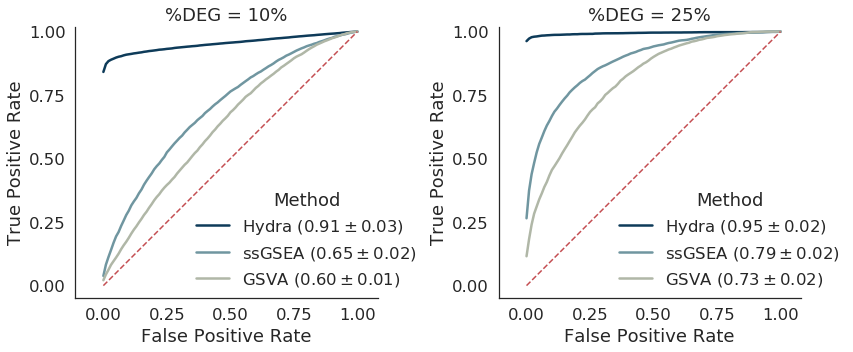

In [15]:
sns.set(style='white', font_scale=1.5)

# based on:
# https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

base_fpr = np.linspace(0, 1, 101)

diff_ind = {'0.10': 0, '0.25': 1}

for color, method, name in zip(palette,
                               ['hydra', 'ssgsea', 'gsva'],
                               ['Hydra', 'ssGSEA', 'GSVA']):

    for diff, l1 in datar[method].items():
        tprs = None
        for eff, l2 in l1.items():
            if float(eff) < 1.0:
                continue
            for gs, (fpr, tpr) in l2.items():
                mask = (plot_df['gene-set'] == gs) & (plot_df['effect'] == float(eff)) & (plot_df['difffrac'] == diff)
                if len(plot_df[mask]) == 0:
                    print('Skipping Lost Model', gs)
                    print(plot_df[mask])
                    continue
                
                #ax.plot(fpr, tpr, label=method)
                btpr = np.interp(base_fpr, fpr, tpr)
            
                if tprs is None:
                    tprs = btpr
            
                else:
                    tprs = np.vstack([btpr, tprs])
                    
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)
    
        ax[diff_ind[diff]].plot([0.] + base_fpr, 
                                [0.] + mean_tprs, 
                                color, 
                                label=name,
                                linewidth=2.5)

for i in [0, 1]:
    ax[i].plot([0, 1], [0, 1],'r--')
    ax[i].set_xlim([-0.05, 1.02])
    ax[i].set_ylim([-0.05, 1.02])

    ax[i].set_ylabel("True Positive Rate")
    ax[i].set_xlabel("False Positive Rate")
    ax[i].set_aspect("equal", 'datalim')
    

ax[0].set_title("%DEG = 10%")
ax[1].set_title("%DEG = 25%")

#plt.title('Mean ROC Curve for HALLMARK Gene Sets')

hy1, hy2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'Hydra') & (plot_df['%DEG'] == '10%') , 'auc'])
ss1, ss2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'ssGSEA') & (plot_df['%DEG'] == '10%'), 'auc'])
gs1, gs2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'GSVA') & (plot_df['%DEG'] == '10%'), 'auc'])

L = ax[0].legend(title='Method', 
                 frameon=False,
                 bbox_to_anchor=(0.35, 0.45))

L.get_texts()[0].set_text("Hydra ($%.2f \pm %.2f$)" % (hy1, hy2))
L.get_texts()[1].set_text("ssGSEA ($%.2f \pm %.2f$)" % (ss1, ss2))
L.get_texts()[2].set_text("GSVA ($%.2f \pm %.2f$)" % (gs1, gs2))

hy1, hy2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'Hydra') & (plot_df['%DEG'] == '25%') , 'auc'])
ss1, ss2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'ssGSEA') & (plot_df['%DEG'] == '25%'), 'auc'])
gs1, gs2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'GSVA') & (plot_df['%DEG'] == '25%'), 'auc'])

L = ax[1].legend(title='Method', 
                 frameon=False,
                 bbox_to_anchor=(0.35, 0.45))

L.get_texts()[0].set_text("Hydra ($%.2f \pm %.2f$)" % (hy1, hy2))
L.get_texts()[1].set_text("ssGSEA ($%.2f \pm %.2f$)" % (ss1, ss2))
L.get_texts()[2].set_text("GSVA ($%.2f \pm %.2f$)" % (gs1, gs2))

sns.despine()


plt.subplots_adjust(wspace=0.4)

pth = '../img/ROC-plot-per-diff.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/ROC-plot-per-diff.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [16]:
plot_df

,method,gene-set,auc,gs_mean,effect,difffrac,%DEG
0,Hydra,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.999091,5.483513,0.50,0.25,25%
1,ssGSEA,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.584739,5.483513,0.50,0.25,25%
2,GSVA,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.637814,5.483513,0.50,0.25,25%
3,Hydra,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.500000,4.090759,0.50,0.25,25%
4,ssGSEA,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.594456,4.090759,0.50,0.25,25%
5,GSVA,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.581069,4.090759,0.50,0.25,25%
6,Hydra,HALLMARK_MYC_TARGETS_V1,0.999928,6.787506,1.50,0.10,10%
7,ssGSEA,HALLMARK_MYC_TARGETS_V1,0.604938,6.787506,1.50,0.10,10%
8,GSVA,HALLMARK_MYC_TARGETS_V1,0.596130,6.787506,1.50,0.10,10%
9,Hydra,HALLMARK_KRAS_SIGNALING_DN,0.921827,3.269809,1.00,0.10,10%


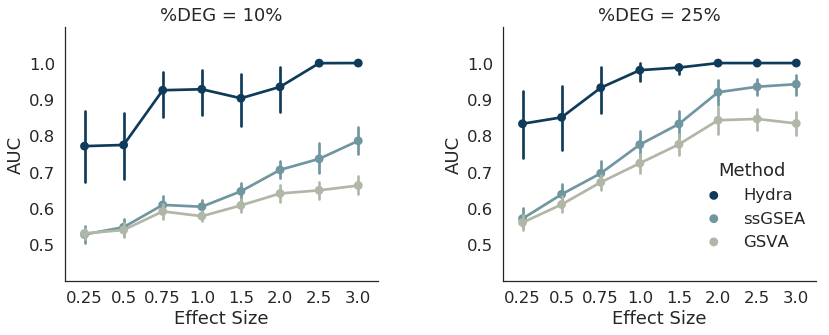

In [17]:
sns.set(style='white', font_scale=1.5)

g = sns.catplot(x='effect', 
                y='auc',
                hue='method',
                col='%DEG',
                col_order=['10%', '25%'],
                kind='point',
                data=plot_df,
                palette=palette,
                scatter_kws={'alpha': 1.0},
                line_kws={'alpha': 1.0},
                sharex=False,
                sharey=False,
                legend=False,
                aspect=1.2)

axes = g.axes

for row in axes:
    for ax in row:
        ax.set_ylim(0.4, 1.1)
        ax.set_xlabel('Effect Size')
        ax.set_ylabel('AUC')
        ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.subplots_adjust(wspace=0.4)

plt.legend(title='Method', frameon=False, loc=(0.6, 0.1))
        
pth = '../img/auc-vs-eff.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/auc-vs-eff.png'
plt.savefig(pth, format='png', bbox_inches='tight')